출처 : https://www.kaggle.com/code/ammarnassanalhajali/uwmgi-unet-keras-train-with-eda#EDA

#import and Setup 

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import os
import cv2
from PIL import Image 
import matplotlib.pyplot as plt
from tqdm import tqdm
from tqdm.notebook import tqdm
from datetime import datetime
import json,itertools
from typing import Optional
from glob import glob

from sklearn.model_selection import StratifiedKFold, KFold, StratifiedGroupKFold


from tensorflow import keras
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Model 
from keras.layers import Input
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.losses import binary_crossentropy
from keras.callbacks import Callback, ModelCheckpoint
from keras.models import load_model

import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib as mpl

In [3]:
# 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

os.chdir('/content/drive/MyDrive/open_directory/test/IMAGE/dataset')
!pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/open_directory/test/IMAGE/dataset


In [ ]:
BATCH_SIZE = 16
EPOCHS=10
n_splits=5
fold_selected=2 # 1..5

In [ ]:
df = pd.read_csv('uw-madison-gi-tract-image-segmentation/train.csv')
print(df.shape)

(115488, 3)


In [ ]:
df

,id,class_name,segmentation,case,day,slice,path,width,height
0,case123_day20_slice_0001,large_bowel,NaN,123,20,0001,uw-madison-gi-tract-image-segmentation/train/c...,266,266
1,case123_day20_slice_0001,small_bowel,NaN,123,20,0001,uw-madison-gi-tract-image-segmentation/train/c...,266,266
2,case123_day20_slice_0001,stomach,NaN,123,20,0001,uw-madison-gi-tract-image-segmentation/train/c...,266,266
3,case123_day20_slice_0002,large_bowel,NaN,123,20,0002,uw-madison-gi-tract-image-segmentation/train/c...,266,266
4,case123_day20_slice_0002,small_bowel,NaN,123,20,0002,uw-madison-gi-tract-image-segmentation/train/c...,266,266
...,...,...,...,...,...,...,...,...,...
115666,case30_day0_slice_0143,small_bowel,NaN,30,0,0143,uw-madison-gi-tract-image-segmentation/train/c...,266,266
115667,case30_day0_slice_0143,stomach,NaN,30,0,0143,uw-madison-gi-tract-image-segmentation/train/c...,266,266
115668,case30_day0_slice_0144,large_bowel,NaN,30,0,0144,uw-madison-gi-tract-image-segmentation/train/c...,266,266
115669,case30_day0_slice_0144,small_bowel,NaN,30,0,0144,uw-madison-gi-tract-image-segmentation/train/c...,266,266


In [ ]:
df.segmentation.nunique()

33899

In [ ]:
33899*3

101697

In [ ]:
print(df['path'][0])
print(df['path'][1])
print(df['path'][2])  # 한 사진이 3장으로 저장되어있다. 0 대장 1 소장 2 배일거라 유추.

uw-madison-gi-tract-image-segmentation/train/case123/case123_day20/scans/slice_0001_266_266_1.50_1.50.png
uw-madison-gi-tract-image-segmentation/train/case123/case123_day20/scans/slice_0001_266_266_1.50_1.50.png
uw-madison-gi-tract-image-segmentation/train/case123/case123_day20/scans/slice_0001_266_266_1.50_1.50.png


In [ ]:
df.rename(columns = {'class':'class_name'}, inplace = True)
#--------------------------------------------------------------------------
df["case"] = df["id"].apply(lambda x: int(x.split("_")[0].replace("case", "")))
df["day"] = df["id"].apply(lambda x: int(x.split("_")[1].replace("day", "")))
df["slice"] = df["id"].apply(lambda x: x.split("_")[3])
#--------------------------------------------------------------------------
TRAIN_DIR="uw-madison-gi-tract-image-segmentation/train"
all_train_images = glob(os.path.join(TRAIN_DIR, "**", "*.png"), recursive=True)
x = all_train_images[0].rsplit("/", 4)[0] ## ../input/uw-madison-gi-tract-image-segmentation/train

path_partial_list = []
for i in range(0, df.shape[0]):
    path_partial_list.append(os.path.join(x,
                          "case"+str(df["case"].values[i]),
                          "case"+str(df["case"].values[i])+"_"+ "day"+str(df["day"].values[i]),
                          "scans",
                          "slice_"+str(df["slice"].values[i])))
df["path_partial"] = path_partial_list
#--------------------------------------------------------------------------
path_partial_list = []
for i in range(0, len(all_train_images)):
    path_partial_list.append(str(all_train_images[i].rsplit("_",4)[0]))
    
tmp_df = pd.DataFrame()
tmp_df['path_partial'] = path_partial_list
tmp_df['path'] = all_train_images

#--------------------------------------------------------------------------
df = df.merge(tmp_df, on="path_partial").drop(columns=["path_partial"])
#--------------------------------------------------------------------------
df["width"] = df["path"].apply(lambda x: int(x[:-4].rsplit("_",4)[1]))
df["height"] = df["path"].apply(lambda x: int(x[:-4].rsplit("_",4)[2]))
#--------------------------------------------------------------------------
del x,path_partial_list,tmp_df
#--------------------------------------------------------------------------
df.head(5)

,id,class_name,segmentation,case,day,slice,path,width,height
0,case123_day20_slice_0001,large_bowel,NaN,123,20,0001,uw-madison-gi-tract-image-segmentation/train/c...,266,266
1,case123_day20_slice_0001,small_bowel,NaN,123,20,0001,uw-madison-gi-tract-image-segmentation/train/c...,266,266
2,case123_day20_slice_0001,stomach,NaN,123,20,0001,uw-madison-gi-tract-image-segmentation/train/c...,266,266
3,case123_day20_slice_0002,large_bowel,NaN,123,20,0002,uw-madison-gi-tract-image-segmentation/train/c...,266,266
4,case123_day20_slice_0002,small_bowel,NaN,123,20,0002,uw-madison-gi-tract-image-segmentation/train/c...,266,266


In [ ]:
# RESTRUCTURE  DATAFRAME
df_train = pd.DataFrame({'id':df['id'][::3]})

df_train['large_bowel'] = df['segmentation'][::3].values  # 대장만
df_train['small_bowel'] = df['segmentation'][1::3].values # 소장만
df_train['stomach'] = df['segmentation'][2::3].values     # 배만

df_train['path'] = df['path'][::3].values                 # 하나의 사진이 3장으로 이루어져있어 경로, case, day등이 같다. 그래서3개씩 건너 뛰는 것.
df_train['case'] = df['case'][::3].values
df_train['day'] = df['day'][::3].values
df_train['slice'] = df['slice'][::3].values
df_train['width'] = df['width'][::3].values
df_train['height'] = df['height'][::3].values


df_train.reset_index(inplace=True,drop=True)
df_train.fillna('',inplace=True); 
df_train['count'] = np.sum(df_train.iloc[:,1:4]!='',axis=1).values
df_train.sample(5)

,id,large_bowel,small_bowel,stomach,path,case,day,slice,width,height,count
4222,case145_day19_slice_0047,,,,uw-madison-gi-tract-image-segmentation/train/c...,145,19,0047,360,310,0
27660,case81_day30_slice_0131,,,,uw-madison-gi-tract-image-segmentation/train/c...,81,30,0131,266,266,0
32966,case54_day39_slice_0055,,,,uw-madison-gi-tract-image-segmentation/train/c...,54,39,0055,266,266,0
3587,case44_day0_slice_0132,,,,uw-madison-gi-tract-image-segmentation/train/c...,44,0,0132,266,266,0
37249,case2_day3_slice_0009,,,,uw-madison-gi-tract-image-segmentation/train/c...,2,3,0009,266,266,0


In [ ]:
"""import numpy as np

indexes = [[[1,3,6,8,0,5,4], [1,3,6,8,0,5,4]],
            [[1,3,6,8,0,5,4],[1,3,6,8,0,5,4]],

            [[1,3,6,8,0,5,4], [1,3,6,8,0,5,4]],
             [[1,3,6,8,0,5,4],[1,3,6,8,0,5,4]]]

indexes = np.array(indexes)"""

3

In [ ]:
# https://gksid102.tistory.com/28
# indexes[0,:,:,0] 설명

IndexError: ignored

In [ ]:
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape, color=1):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()  # 기본 값 ' '
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]  #큰 값 start, 작은 값 lengths 짝수 홀수로 나눔.
    starts -= 1 
    ends = starts + lengths 
    img = np.zeros((shape[0] * shape[1], shape[2]), dtype=np.float32) # shape = (128,128,1)  -> (???,1) flatten 효과
    for lo, hi in zip(starts, ends):
        img[lo : hi] = color  # 값이 있는 부분에 1을 넣어준다.  
    return img.reshape(shape)


def build_masks(labels,input_shape, colors=True):
    height, width = input_shape
    if colors:
        mask = np.zeros((height, width, 3))
        for label in labels:
            mask += rle_decode(label, shape=(height,width , 3), color=np.random.rand(3))
    else:
        mask = np.zeros((height, width, 1))
        for label in labels:
            mask += rle_decode(label, shape=(height, width, 1))
    mask = mask.clip(0, 1)
    return mask

In [ ]:
a = np.empty((2,2,2),dtype = int)
a[1,] 

array([[4, 5],
       [6, 7]])

In [ ]:
import keras
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, batch_size = BATCH_SIZE, subset="train", shuffle=False):
        super().__init__()
        self.df = df
        self.shuffle = shuffle
        self.subset = subset
        self.batch_size = batch_size
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))  # np.floor 내림값 반환 함수 (3.6 -> 3)
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))  # df의 길이만큼 인덱스 배열을 만들어준다.
        if self.shuffle == True:
            np.random.shuffle(self.indexes)     # 데이터 섞이면 인덱스도 섞어준다.
    
    def __load_grayscale(self, img_path):
        img = cv2.imread(img_path, cv2.IMREAD_ANYDEPTH)
        dsize = (128, 128)
        img = cv2.resize(img, dsize)
        img = img.astype(np.float32) / 255. # normarlize 왜 하는 걸까?
        img = np.expand_dims(img, axis=-1)  # 마지막 차원 추가.
        return img  # 사이즈를 전부 통일해준다.

    def __getitem__(self, index): 
        X = np.empty((self.batch_size,128,128,3)) # 4차원
        y = np.empty((self.batch_size,128,128,3)) # np.empty= 셰입이나 데이터 타입만 알려주면 아무 값이나 들어간 행렬을 만든다.
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size] # 16개씩 가져오려고 한다.
        for i,img_path in enumerate(self.df['path'].iloc[indexes]): # path는 폴더 내 이미지 이름. 배열을 iloc에 넣어주면 이미지 경로가 출력된다.
            w=self.df['width'].iloc[indexes[i]]           
            h=self.df['height'].iloc[indexes[i]]
            img = self.__load_grayscale(img_path) # 3차원 (128,128,1)
            X[i,] =img  # (i, 128, 128, 1)
            if self.subset == 'train':
                for k,j in zip([0,1,2],["large_bowel","small_bowel","stomach"]):
                    rles=self.df[j].iloc[indexes[i]]
                    masks = rle_decode(rles, shape=(h, w, 1)) # 해당 위치를 '1' 로 마스크 시킨다.
                    #rles=df_train[j][df_train.index==indexes[i]]
                    #masks = build_masks(rles,(h,w), colors=False)
                    masks = cv2.resize(masks, (128, 128)) # 그림 크기 똑같이.
                    y[i,:,:,k] = masks  # 대장, 소장, 배 각각 마스크.
        if self.subset == 'train': return X, y
        else: return X  # 학습이 아닌 경우는 X 리턴.
        


#EDA

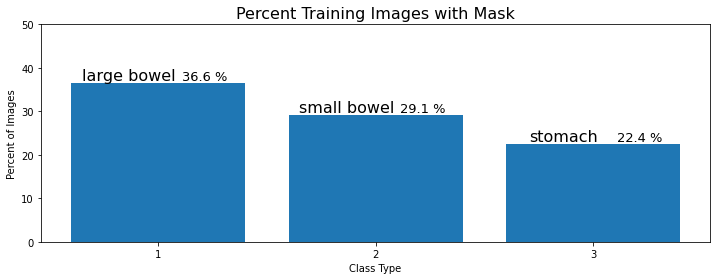

In [ ]:
plt.figure(figsize=(12,4))
bar = plt.bar([1,2,3],100*np.mean( df_train.iloc[:,1:4]!='',axis=0))
plt.title('Percent Training Images with Mask', fontsize=16)
plt.ylabel('Percent of Images'); plt.xlabel('Class Type')
plt.xticks([1,2,3])
labels=["large bowel","small bowel","stomach"]
for rect,lbl in zip(bar,labels):
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/3, height,  lbl,
             ha='center', va='bottom',fontsize=16)
    plt.text(rect.get_x() + rect.get_width()/1.3, height, '%.1f %%' % height,
             ha='center', va='bottom',fontsize=13)

plt.ylim((0,50)); plt.show()

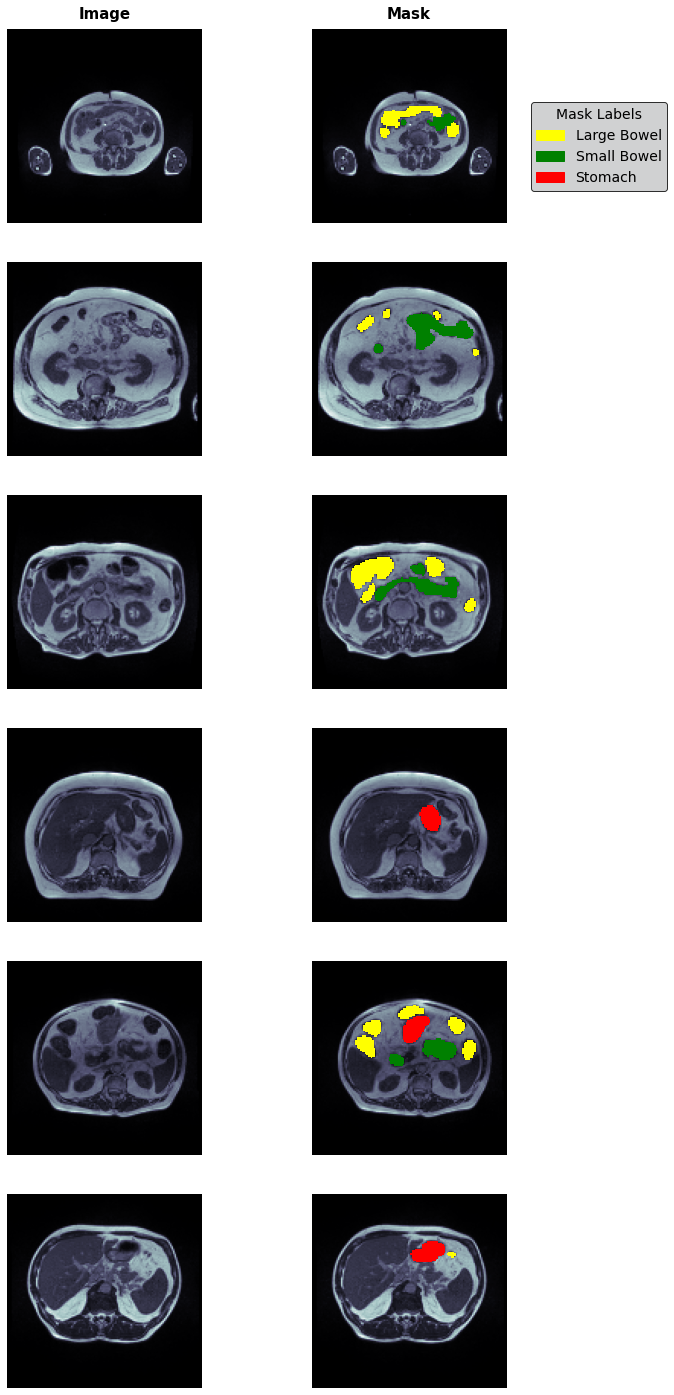

In [ ]:
# SAMPLES 무작위로 16, 32, 48개의 행 인덱스를 가지고 온다.
Masks = list(df_train[df_train['large_bowel']!=''].sample(BATCH_SIZE).index)
Masks += list(df_train[df_train['small_bowel']!=''].sample(BATCH_SIZE*2).index)
Masks += list(df_train[df_train['stomach']!=''].sample(BATCH_SIZE*3).index)


# DATA GENERATOR 96개의 데이터
View_batches = DataGenerator(df_train[df_train.index.isin(Masks)],shuffle=True)

# Visualizing
fig = plt.figure(figsize=(10, 25))
gs = gridspec.GridSpec(nrows=6, ncols=2)
colors = ['yellow','green','red']
labels = ["Large Bowel", "Small Bowel", "Stomach"]
patches = [ mpatches.Patch(color=colors[i], label=f"{labels[i]}") for i in range(len(labels))]

cmap1 = mpl.colors.ListedColormap(colors[0])  # 대장
cmap2 = mpl.colors.ListedColormap(colors[1])  # 소장
cmap3= mpl.colors.ListedColormap(colors[2])   # 배

for i in range(6):
    images, mask = View_batches[i]
    sample_img=images[0,:,:,0]
    mask1=mask[0,:,:,0]
    mask2=mask[0,:,:,1]
    mask3=mask[0,:,:,2]
    
    ax0 = fig.add_subplot(gs[i, 0])
    im = ax0.imshow(sample_img, cmap='bone')

    ax1 = fig.add_subplot(gs[i, 1])
    if i==0:
        ax0.set_title("Image", fontsize=15, weight='bold', y=1.02)
        ax1.set_title("Mask", fontsize=15, weight='bold', y=1.02)
        plt.legend(handles=patches, bbox_to_anchor=(1.1, 0.65), loc=2, borderaxespad=0.4,fontsize = 14,title='Mask Labels', title_fontsize=14, edgecolor="black",  facecolor='#c5c6c7')

    l0 = ax1.imshow(sample_img, cmap='bone')
    l1 = ax1.imshow(np.ma.masked_where(mask1== False,  mask1),cmap=cmap1, alpha=1)
    l2 = ax1.imshow(np.ma.masked_where(mask2== False,  mask2),cmap=cmap2, alpha=1)
    l3 = ax1.imshow(np.ma.masked_where(mask3== False,  mask3),cmap=cmap3, alpha=1)  # 변수 선언과 동시에 프린트되는 이미지들. (print)
    _ = [ax.set_axis_off() for ax in [ax0,ax1]]

    colors = [im.cmap(im.norm(1)) for im in [l1,l2, l3]] .

#Training

In [ ]:
df_train

,id,large_bowel,small_bowel,stomach,path,case,day,slice,width,height,count
0,case123_day20_slice_0001,,,,uw-madison-gi-tract-image-segmentation/train/c...,123,20,0001,266,266,0
1,case123_day20_slice_0002,,,,uw-madison-gi-tract-image-segmentation/train/c...,123,20,0002,266,266,0
2,case123_day20_slice_0003,,,,uw-madison-gi-tract-image-segmentation/train/c...,123,20,0003,266,266,0
3,case123_day20_slice_0004,,,,uw-madison-gi-tract-image-segmentation/train/c...,123,20,0004,266,266,0
4,case123_day20_slice_0005,,,,uw-madison-gi-tract-image-segmentation/train/c...,123,20,0005,266,266,0
...,...,...,...,...,...,...,...,...,...,...,...
38552,case30_day0_slice_0140,,,,uw-madison-gi-tract-image-segmentation/train/c...,30,0,0140,266,266,0
38553,case30_day0_slice_0141,,,,uw-madison-gi-tract-image-segmentation/train/c...,30,0,0141,266,266,0
38554,case30_day0_slice_0142,,,,uw-madison-gi-tract-image-segmentation/train/c...,30,0,0142,266,266,0
38555,case30_day0_slice_0143,,,,uw-madison-gi-tract-image-segmentation/train/c...,30,0,0143,266,266,0


SAMPLES

In [ ]:
train_mask = list(df_train[df_train['large_bowel']!=''].index) 
train_mask += list(df_train[df_train['small_bowel']!=''].index) 
train_mask += list(df_train[df_train['stomach']!=''].index)     # 해당하는 인덱스 전부 다 리스트.

df_train=df_train[df_train.index.isin(train_mask)]              # 인덱스 값이 저 리스트에 들어있는 것만 df train으로.
df_train.reset_index(inplace=True,drop=True) 
print(df_train.shape)

(16608, 11)


CV

In [ ]:
skf = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=42)
for fold, (_, val_idx) in enumerate(skf.split(X=df_train, y=df_train['count'],groups =df_train['case']), 1):
    df_train.loc[val_idx, 'fold'] = fold
    
df_train['fold'] = df_train['fold'].astype(np.uint8)

train_ids = df_train[df_train["fold"]!=fold_selected].index
valid_ids = df_train[df_train["fold"]==fold_selected].index

df_train.groupby('fold').size()

fold
1    3574
2    2820
3    3052
4    3417
5    3745
dtype: int64

In [ ]:
display(df_train.groupby(['fold','count'])['id'].count())

fold  count
1     1         634
      2        2240
      3         700
2     1         372
      2        1867
      3         581
3     1         381
      2        2047
      3         624
4     1         582
      2        2194
      3         641
5     1         502
      2        2576
      3         667
Name: id, dtype: int64

In [ ]:
train_generator = DataGenerator(df_train[df_train.index.isin(train_ids)],shuffle=True)
val_generator = DataGenerator(df_train[df_train.index.isin(valid_ids)])

UNET model¶

In [ ]:
from keras import backend as K
from keras.losses import binary_crossentropy
import tensorflow as tf

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(tf.cast(y_true, tf.float32), y_pred) + 0.5 * dice_loss(tf.cast(y_true, tf.float32), y_pred)

In [ ]:
! pip install segmentation-models

In [ ]:
! pip install git+https://github.com/qubvel/segmentation_models

  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-r9qhco1c
  Running command git clone -q https://github.com/qubvel/segmentation_models /tmp/pip-req-build-r9qhco1c
  Running command git submodule update --init --recursive -q


In [ ]:
import segmentation_models as sm
sm.set_framework('tf.keras')
sm.framework()

Segmentation Models: using `keras` framework.


'tf.keras'

In [ ]:
from segmentation_models import Unet
from segmentation_models.utils import set_trainable

model = Unet('efficientnetb7',input_shape=(128, 128, 3), classes=3, activation='sigmoid',encoder_weights='imagenet')
model.compile(optimizer='adam', loss=bce_dice_loss,metrics=[dice_coef,iou_coef]) #binary_crossentropy
model.summary()

258449408/258434480 [==============================] - 16s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv (Conv2D)             (None, 64, 64, 64)   1728        ['input_1[0][0]']                
                                                                                                  
 stem_bn (BatchNormalization)   (None, 64, 64, 64)   256         ['stem_conv[0][0]']              
                                                                                                  
 stem_activation (Activati

#Training model

In [ ]:
from keras.callbacks import Callback, ModelCheckpoint
checkpoint = ModelCheckpoint(
    'model.h5', 
    monitor='val_loss', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    callbacks=[checkpoint],
    use_multiprocessing=False,
    workers=4,
    epochs=EPOCHS
)

Epoch 1/10
861/861 [==============================] - ETA: 0s - loss: 0.2272 - dice_coef: 0.6323 - iou_coef: 0.4753
Epoch 1: val_loss improved from inf to 0.20958, saving model to model.h5
861/861 [==============================] - 1137s 1s/step - loss: 0.2272 - dice_coef: 0.6323 - iou_coef: 0.4753 - val_loss: 0.2096 - val_dice_coef: 0.6582 - val_iou_coef: 0.5004
Epoch 2/10
861/861 [==============================] - ETA: 0s - loss: 0.1037 - dice_coef: 0.8253 - iou_coef: 0.6993
Epoch 2: val_loss improved from 0.20958 to 0.18651, saving model to model.h5
861/861 [==============================] - 1005s 1s/step - loss: 0.1037 - dice_coef: 0.8253 - iou_coef: 0.6993 - val_loss: 0.1865 - val_dice_coef: 0.7002 - val_iou_coef: 0.5465
Epoch 3/10
861/861 [==============================] - ETA: 0s - loss: 0.0895 - dice_coef: 0.8496 - iou_coef: 0.7347
Epoch 3: val_loss improved from 0.18651 to 0.17334, saving model to model.h5
861/861 [==============================] - 1006s 1s/step - loss: 0.0895

#Predict From Valiation Set - 저장된 모델로 작동가능

In [ ]:
custom_objects = custom_objects={
    'dice_coef': dice_coef,
    'iou_coef': iou_coef,
    'bce_dice_loss': bce_dice_loss  
}
model = load_model('./model.h5', custom_objects=custom_objects)

In [ ]:
pred_batches = DataGenerator(df_train[df_train.index.isin(valid_ids[0:8])],batch_size = 1,shuffle=False)
preds = model.predict_generator(pred_batches,verbose=1)

8/8 [==============================] - 6s 105ms/step


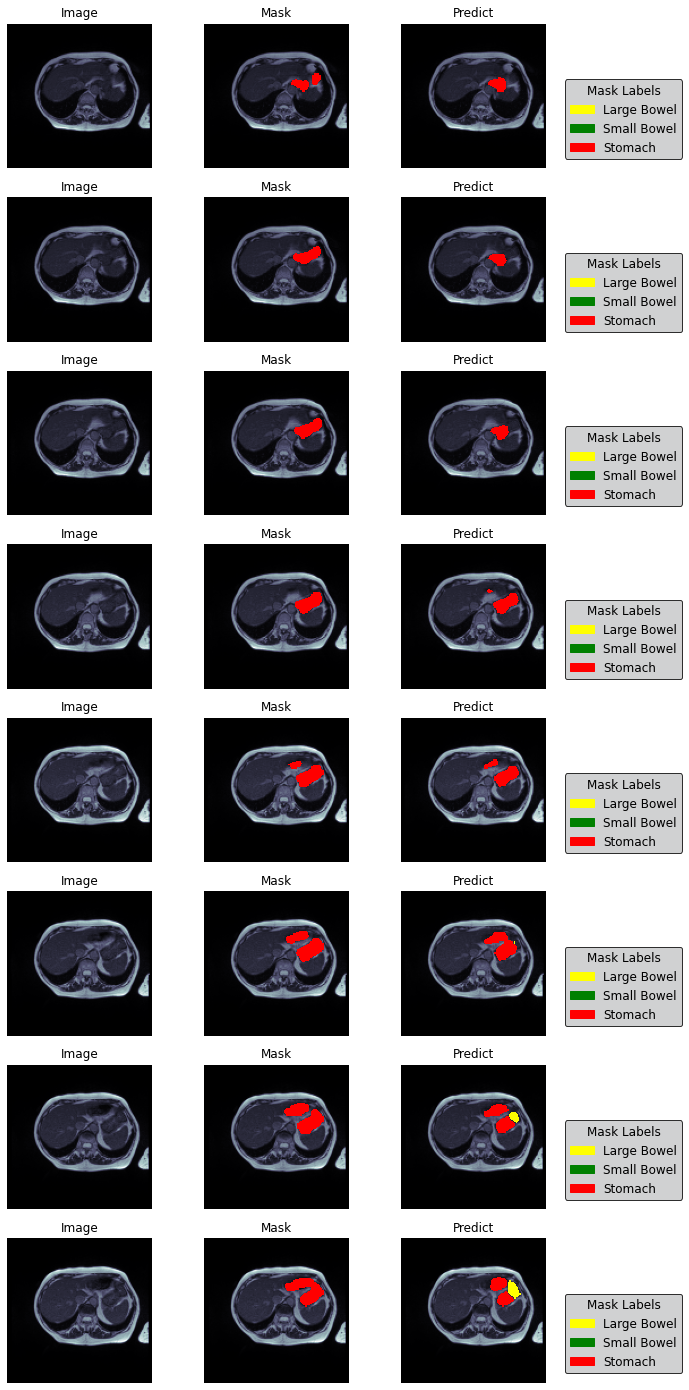

In [ ]:
Threshold = 0.1
# Visualizing
fig = plt.figure(figsize=(10, 25))
gs = gridspec.GridSpec(nrows=8, ncols=3)
colors = ['yellow','green','red']
labels = ["Large Bowel", "Small Bowel", "Stomach"]
patches = [ mpatches.Patch(color=colors[i], label=f"{labels[i]}") for i in range(len(labels))]

cmap1 = mpl.colors.ListedColormap(colors[0])
cmap2 = mpl.colors.ListedColormap(colors[1])
cmap3= mpl.colors.ListedColormap(colors[2])

for i in range(8):
    images, mask = pred_batches[i]
    sample_img=images[0,:,:,0]
    mask1=mask[0,:,:,0]
    mask2=mask[0,:,:,1]
    mask3=mask[0,:,:,2]
    
    pre=preds[i]
    predict1=pre[:,:,0]
    predict2=pre[:,:,1]
    predict3=pre[:,:,2]
    
    predict1= (predict1 > Threshold).astype(np.float32)
    predict2= (predict2 > Threshold).astype(np.float32)
    predict3= (predict3 > Threshold).astype(np.float32)
    
    ax0 = fig.add_subplot(gs[i, 0])
    im = ax0.imshow(sample_img, cmap='bone')
    ax0.set_title("Image", fontsize=12, y=1.01)
    #--------------------------
    ax1 = fig.add_subplot(gs[i, 1])
    ax1.set_title("Mask", fontsize=12,  y=1.01)
    l0 = ax1.imshow(sample_img, cmap='bone')
    l1 = ax1.imshow(np.ma.masked_where(mask1== False,  mask1),cmap=cmap1, alpha=1)
    l2 = ax1.imshow(np.ma.masked_where(mask2== False,  mask2),cmap=cmap2, alpha=1)
    l3 = ax1.imshow(np.ma.masked_where(mask3== False,  mask3),cmap=cmap3, alpha=1)
    #--------------------------
    ax2 = fig.add_subplot(gs[i, 2])
    ax2.set_title("Predict", fontsize=12, y=1.01)
    l0 = ax2.imshow(sample_img, cmap='bone')
    l1 = ax2.imshow(np.ma.masked_where(predict1== False,  predict1),cmap=cmap1, alpha=1)
    l2 = ax2.imshow(np.ma.masked_where(predict2== False,  predict2),cmap=cmap2, alpha=1)
    l3 = ax2.imshow(np.ma.masked_where(predict3== False,  predict3),cmap=cmap3, alpha=1)
   

    _ = [ax.set_axis_off() for ax in [ax0,ax1,ax2]]
    colors = [im.cmap(im.norm(1)) for im in [l1,l2, l3]]
    plt.legend(handles=patches, bbox_to_anchor=(1.1, 0.65), loc=2, borderaxespad=0.4,fontsize = 12,title='Mask Labels', title_fontsize=12, edgecolor="black",  facecolor='#c5c6c7')